In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from pprint import pprint

%matplotlib inline

## Downloading

In [3]:
with open('names.txt', 'r', encoding='utf-8') as file:
    names = file.read().split('\n')

In [4]:
print('Number of items:', len(names))

Number of items: 1493


In [5]:
pprint(names[:5])

['ЭПЛАРО 2-местный модульный диван, садовый',
 'СУННЕРСТА тележка',
 'ХЕМНЭС консольный стол',
 'ПОЭНГ кресло',
 'МИТТБИТ салфетка под приборы']


Max length: 63


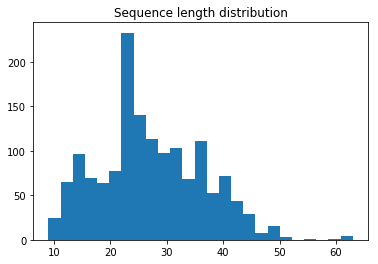

In [6]:
MAX_LENGTH = max(map(len, names))
print('Max length:', MAX_LENGTH)

plt.title('Sequence length distribution')
_ = plt.hist(list(map(len, names)), bins=25)

## Preprocessing

In [7]:
tokens = list(set(''.join(names)))
print('Size of alphabet:', len(tokens))

Size of alphabet: 81


In [8]:
token_to_id = {token: idx for idx, token in enumerate(tokens)}
PAD_IX = token_to_id[' ']

In [9]:
def to_matrix(lines, max_len=None, pad=PAD_IX, dtype='int32', batch_first=True):
    '''Casts a list of names into matrix with tokens id'''
    
    max_len = max_len or MAX_LENGTH
    lines_ix = np.zeros([len(lines), max_len], dtype) + pad

    for i in range(len(lines)):
        line_ix = [token_to_id[c] for c in lines[i]]
        lines_ix[i, :len(line_ix)] = line_ix
        
    if not batch_first: # convert [batch, time] into [time, batch]
        lines_ix = np.transpose(lines_ix)

    return lines_ix

In [10]:
# Example: cast 4 random names to matrices, pad with zeros
print('\n'.join(names[::500]))
print(to_matrix(names[::500]))

ЭПЛАРО 2-местный модульный диван, садовый
ДЮГРИП стакан
ИНДУСТРИЕЛЛ подвесной светильник
[[17 54  4  8 51  9 35 80 71 67 19 39 28 29 30 20 35 67 58 18 68 57 76 29
  30 20 35 18  5 61 53 29 55 35 39 53 18 58 61 30 20 35 35 35 35 35 35 35
  35 35 35 35 35 35 35 35 35 35 35 35 35 35 35]
 [43 26 32 51 16 54 35 39 28 53 70 53 29 35 35 35 35 35 35 35 35 35 35 35
  35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35
  35 35 35 35 35 35 35 35 35 35 35 35 35 35 35]
 [16  6 43 15 34 36 51 16 12  4  4 35 69 58 18 61 19 39 29 58 20 35 39 61
  19 28  5 57 76 29  5 70 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35
  35 35 35 35 35 35 35 35 35 35 35 35 35 35 35]]


## Network

In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CharRNNCell(nn.Module):
    """
    Implement the scheme above as torch module
    """
    def __init__(self, num_tokens=len(tokens), embedding_size=16, rnn_num_units=64):
        super().__init__()
        self.num_units = rnn_num_units
        
        self.embedding = nn.Embedding(num_tokens, embedding_size)
        self.rnn_update = nn.Linear(embedding_size + rnn_num_units, rnn_num_units)
        self.rnn_to_logits = nn.Linear(rnn_num_units, num_tokens)
        
    def forward(self, x, h_prev):
        """
        This method computes h_next(x, h_prev) and log P(x_next | h_next)
        We'll call it repeatedly to produce the whole sequence.
        
        :param x: batch of character ids, int64[batch_size]
        :param h_prev: previous rnn hidden states, float32 matrix [batch, rnn_num_units]
        """
        x_emb = self.embedding(x)
        
        h_next = self.rnn_update(torch.cat((h_prev, x_emb), dim=1))
        
        h_next = torch.tanh(h_next)
        
        logits = self.rnn_to_logits(h_next)
        
        return h_next, F.log_softmax(logits, -1)
    
    def initial_state(self, batch_size):
        """ return rnn state before it processes first input (aka h0) """
        return torch.zeros(batch_size, self.num_units)

In [12]:
def rnn_loop(char_rnn, batch_ix):
    """
    Computes log P(next_character) for all time-steps in lines_ix
    :param lines_ix: an int32 matrix of shape [batch, time], output of to_matrix(lines)
    """
    batch_size, max_length = batch_ix.size()
    hid_state = char_rnn.initial_state(batch_size)
    logprobs = []

    for x_t in batch_ix.transpose(0, 1):
        hid_state, logp_next = char_rnn(x_t, hid_state)  # <-- here we call your one-step code
        logprobs.append(logp_next)
        
    return torch.stack(logprobs, dim=1)

## Training loop

In [15]:
from IPython.display import clear_output
from random import sample

char_rnn = CharRNNCell()
opt = torch.optim.Adam(char_rnn.parameters())
history = []

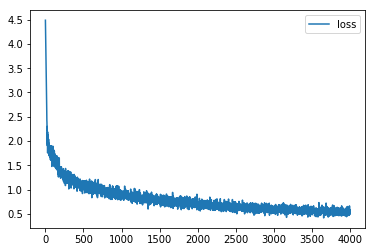

In [20]:
for i in range(2500, 4000):
    batch_ix = to_matrix(sample(names, 32), max_len=MAX_LENGTH)
    batch_ix = torch.tensor(batch_ix, dtype=torch.int64)
    
    logp_seq = rnn_loop(char_rnn, batch_ix)
    
    predictions_logp = logp_seq[:, :-1]
    actual_next_tokens = batch_ix[:, 1:]

    logp_next = torch.gather(predictions_logp, dim=2, index=actual_next_tokens[:, :, None])

    loss = -logp_next.mean()
    
    opt.zero_grad()
    loss.backward()
    opt.step()
    
    history.append(loss.data.numpy())
    if (i + 1) % 100 == 0:
        clear_output(True)
        plt.plot(history, label='loss')
        plt.legend()
        plt.show()

assert np.mean(history[:10]) > np.mean(history[-10:]), "RNN didn't converge."